In [ ]:
from google.colab import drive
drive.mount('/content/drive') # Mount to the 'MyDrive' directory

Mounted at /content/drive


In [ ]:
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/NSE-TATAGLOBAL.csv')


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense



In [ ]:
data = pd.read_csv('/content/drive/MyDrive/NSE-TATAGLOBAL.csv', date_parser=True)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)



<ipython-input-17-f26b84013802>:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv('/content/drive/MyDrive/NSE-TATAGLOBAL.csv', date_parser=True)


In [ ]:
# Sort the data by date if necessary
data = data.sort_index()

# Feature Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

# Splitting the data
training_size = int(len(scaled_data) * 0.7)
train_data = scaled_data[:training_size]
test_data = scaled_data[training_size:]

def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60  # Adjust as necessary


In [ ]:
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the Stacked LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)



Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 0.0200
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0025
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 0.0014
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.0013
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0012
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0012
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.0012
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - loss: 0.0012
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0011
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0010
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 9.7139e-04
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 9.7369e-04
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 9.0606e-04
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - loss: 9.2153e-04
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/s

In [ ]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse scaling the predictions and actual values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))




43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Train RMSE: 2.85
Test RMSE: 6.90


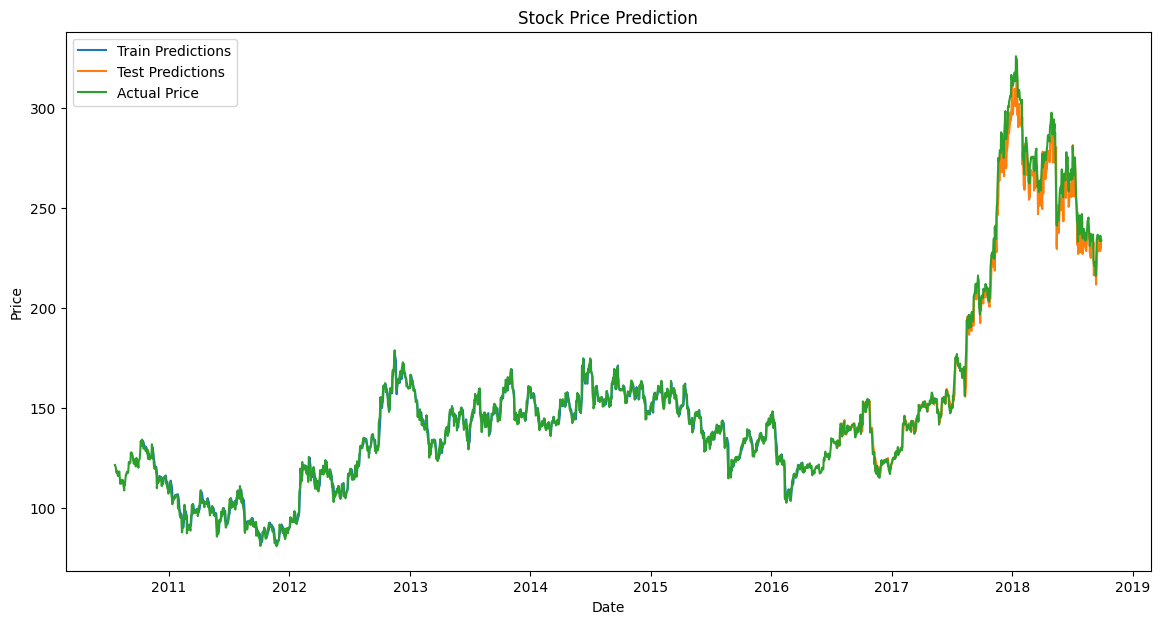

In [ ]:
# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

# Visualize the predictions
plt.figure(figsize=(14, 7))

# Adjust the plotting indices
train_len = len(train_predict)
test_len = len(test_predict)
total_len = len(data)

plt.plot(data.index[time_step:train_len+time_step], train_predict, label='Train Predictions')
plt.plot(data.index[train_len+(time_step*2)+1:total_len-1], test_predict, label='Test Predictions')
plt.plot(data.index, data['Close'], label='Actual Price')

plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# New Section